In [226]:
import os
import numpy as np
import json
import glob
import argparse
from IPython.display import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from attgan import AttGAN
from utils import find_model
from data import check_attribute_conflict, CelebA

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load model

In [11]:
%ls output/256_shortcut1_inject1_none

checkpoint/  setting.txt


In [15]:
custom_args = dict(
    experiment_name='256_shortcut1_inject1_none',
    test_atts=None, # attribute
    test_ints=None, # intensity
    num_test=None,
    load_epoch='latest',
    custom_img=False,
    custom_data=None,
    custom_attr=None,
    gpu=True,
    multi_gpu=False,
)

In [18]:
experiment_name = '256_shortcut1_inject1_none'

In [25]:
with open(os.path.join('./output', experiment_name, 'setting.txt'), 'r') as f:
    args = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
args.gpu = False
args.multi_gpu = False

In [34]:
attgan = AttGAN(args)
attgan.load(find_model(os.path.join('./output', experiment_name, 'checkpoint'), 'latest'))
attgan.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 128, 128]           3,072
       BatchNorm2d-2          [4, 64, 128, 128]             128
         LeakyReLU-3          [4, 64, 128, 128]               0
       Conv2dBlock-4          [4, 64, 128, 128]               0
            Conv2d-5           [4, 128, 64, 64]         131,072
       BatchNorm2d-6           [4, 128, 64, 64]             256
         LeakyReLU-7           [4, 128, 64, 64]               0
       Conv2dBlock-8           [4, 128, 64, 64]               0
            Conv2d-9           [4, 256, 32, 32]         524,288
      BatchNorm2d-10           [4, 256, 32, 32]             512
        LeakyReLU-11           [4, 256, 32, 32]               0
      Conv2dBlock-12           [4, 256, 32, 32]               0
           Conv2d-13           [4, 512, 16, 16]       2,097,152
      BatchNorm2d-14           [4, 512,

### Load dataset

In [144]:
bsize = 1
img_size = 256

dset = CelebA('./data/img_align_celeba/', './data/list_attr_celeba.txt', 
              img_size, 'train', args.attrs)
dl = DataLoader(dset, batch_size=bsize, shuffle=False,
                      drop_last=False, num_workers=8)

### Inference

In [217]:
index = 1
xs, cs = dset[index]
xs, cs = xs.unsqueeze(0), cs.unsqueeze(0)

In [218]:
args.attrs

['Bald',
 'Bangs',
 'Black_Hair',
 'Blond_Hair',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Eyeglasses',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'No_Beard',
 'Pale_Skin',
 'Young']

In [219]:
test_atts = ['Male']
test_ints = [1]

In [220]:
for a in test_atts:
    i = args.attrs.index(a)
    cs[:, i] = 1 - cs[:, i]
    # cs = check_attribute_conflict(cs, args.attrs[i], args.attrs)
cs = (cs * 2 - 1) * args.thres_int
for a, i in zip(test_atts, test_ints):
    cs[..., args.attrs.index(a)] = cs[..., args.attrs.index(a)] * i / args.thres_int

In [221]:
with torch.no_grad():
    gen_xs = attgan.G(xs, cs)

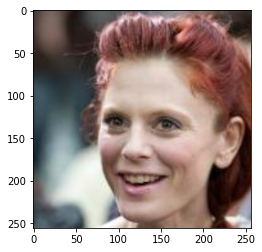

In [222]:
plt.imshow(((xs[0] + 1.) / 2.).permute(1, 2, 0))
plt.show()

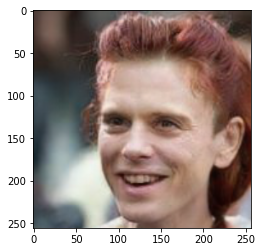

In [223]:
plt.imshow(((gen_xs[0] + 1.) / 2.).permute(1, 2, 0))
plt.show()

### Visualize results

In [240]:
orig_dir = '/home/andrewbai/data/celeba/img_align_celeba/'
gen_dir = '/home/andrewbai/data/celeba_attgan/CelebA_cg-chain_rule_independent_ft-x2y_k1/images/'

In [242]:
gen_img_paths = glob.glob(os.path.join(gen_dir, "*.jpg"))

In [270]:
index = 10

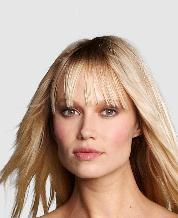

In [271]:
Image(filename=os.path.join(orig_dir, gen_img_paths[index].split('/')[-1]))

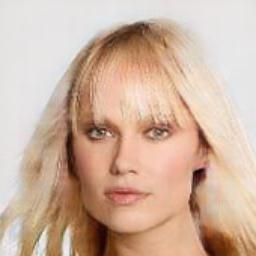

In [272]:
Image(filename=gen_img_paths[index])